# Debug | Timestamp Analysis

# Todo
- 画面内の時計の時刻と、ファイル名の時刻の誤差を集計
- 切片0の線形回帰を行い、傾きを求める ==> タイムスタンプの補正項として使用

# Note:
- 画面内の時計を基準のタイムスタンプと考える.

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model

/Users/yoshimuranaoya/.pyenv/versions/3.9.7/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## [1] データの読み込み & 可視化

In [3]:
path = Path("../data/20220112/timestamp_check.csv")
df1 = pd.read_csv(path)
df1["mode"] = "Before Fix"

path = Path("../data/20220113/timestamp_check.csv")
df2 = pd.read_csv(path)

df = pd.concat([df1, df2], axis=0)

# Preprocessing
df = df.drop("Unnamed: 5", axis=1)
df = df[~df["User"].isnull()]
df = df.sort_values(by=["User", "Session", "ts_clock"])

In [4]:
df.head(20)

,User,Session,ts_clock,ts_fname_sec,ts_fname_ms,elapsed_time_sec,delta,mode
0,U0005,S0100,11:14:11,11:14:11,0.0,0.0,0.000,Before Fix
1,U0005,S0100,11:15:00,11:15:00,133.0,49.0,0.133,Before Fix
2,U0005,S0100,11:20:00,11:19:59,800.0,349.0,-0.200,Before Fix
3,U0005,S0100,11:25:00,11:24:59,933.0,649.0,-0.067,Before Fix
4,U0005,S0100,11:30:00,11:29:59,600.0,949.0,-0.400,Before Fix
5,U0005,S0100,11:35:00,11:34:59,333.0,1249.0,-0.667,Before Fix
6,U0005,S0100,11:40:00,11:39:59,533.0,1549.0,-0.467,Before Fix
7,U0005,S0100,11:45:00,11:44:59,200.0,1849.0,-0.800,Before Fix
8,U0005,S0100,11:50:00,11:49:58,933.0,2149.0,-1.067,Before Fix
9,U0005,S0100,11:55:00,11:54:59,0.0,2449.0,-1.000,Before Fix


x=(122,), y=(122,)


/var/folders/dm/z_k23pbx6y78kywxjbsfpm8c0000gn/T/ipykernel_54358/1788939477.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


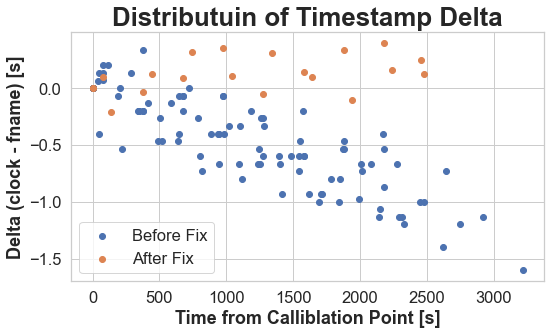

In [6]:
sns.set("notebook", "whitegrid", font_scale=1.5)

df_before = df[df["mode"] == "Before Fix"] 
x1 = df_before["elapsed_time_sec"].values
y1 = df_before["delta"].values
print(f"x={x.shape}, y={y.shape}")

df_after = df[df["mode"] == "After Fix"] 
x2 = df_after["elapsed_time_sec"].values
y2 = df_after["delta"].values

fig, ax0 = plt.subplots(1, 1, figsize=(8, 5))
ax0.scatter(x1, y1, label="Before Fix", color="C0")
ax0.scatter(x2, y2, label="After Fix", color="C1")
ax0.set_xlabel("Time from Calliblation Point [s]", fontweight="bold")
ax0.set_ylabel("Delta (clock - fname) [s]", fontweight="bold")
ax0.set_title("Distributuin of Timestamp Delta", fontsize="x-large", fontweight="bold")
ax0.legend(loc="lower left")

fig.tight_layout()
fig.show()

## [2] 線形回帰 (Before Fix)

### 切片なし

In [33]:
x = df["elapsed_time_sec"].values.reshape(-1, 1)
y = df["delta"].values # .reshape(1, -1)
print(f"x={x.shape}, y={y.shape}")

model = linear_model.LinearRegression(fit_intercept=False)
model.fit(x, y)

print(model.coef_, model.intercept_, model.score(x, y))

x=(91, 1), y=(91,)
[-0.00042629] 0.0 0.7590826786108845


/var/folders/dm/z_k23pbx6y78kywxjbsfpm8c0000gn/T/ipykernel_44385/3022572612.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


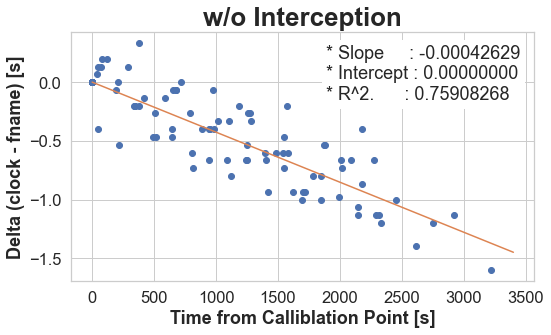

In [34]:
# == Plot ==
fig, ax0 = plt.subplots(1, 1, figsize=(8, 5))

# Raw data
ax0.scatter(x, y, color="C0")

# Trend Line
xloc = np.arange(0, 3500, 100)
y_pred = model.predict(xloc.reshape(-1, 1))
ax0.plot(xloc, y_pred, color="C1")

# Memo
ax0.text(
    0.550, 0.95,
    (
        f"* Slope     : {model.coef_[0]:.8f}\n"
        f"* Intercept : {model.intercept_:.8f}\n"
        f"* R^2.      : {model.score(x, y):.8f}"        
    ),
    backgroundcolor="white",
    ha="left", va="top",
    transform=ax0.transAxes,
)

ax0.set_xlabel("Time from Calliblation Point [s]", fontweight="bold")
ax0.set_ylabel("Delta (clock - fname) [s]", fontweight="bold")
ax0.set_title("w/o Interception", fontsize="x-large", fontweight="bold")

fig.tight_layout()
fig.show()

### 切片あり

In [36]:
x = df["elapsed_time_sec"].values.reshape(-1, 1)
y = df["delta"]
print(f"x={x.shape}, y={y.shape}")

model = linear_model.LinearRegression(fit_intercept=True)
model.fit(x, y)

print(model.coef_, model.intercept_, model.score(x, y))

x=(91, 1), y=(91,)
[-0.00043908] 0.02197046063587038 0.7600890194918082


/var/folders/dm/z_k23pbx6y78kywxjbsfpm8c0000gn/T/ipykernel_44385/283646501.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


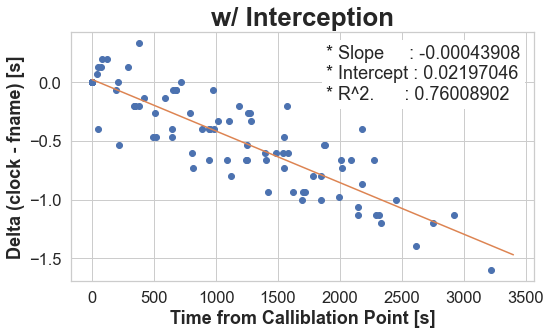

In [37]:
# == Plot ==
fig, ax0 = plt.subplots(1, 1, figsize=(8, 5))

# Raw data
ax0.scatter(x, y, color="C0")

# Trend Line
xloc = np.arange(0, 3500, 100)
y_pred = model.predict(xloc.reshape(-1, 1))
ax0.plot(xloc, y_pred, color="C1")

# Memo
ax0.text(
    0.550, 0.95,
    (
        f"* Slope     : {model.coef_[0]:.8f}\n"
        f"* Intercept : {model.intercept_:.8f}\n"
        f"* R^2.      : {model.score(x, y):.8f}"        
    ),
    backgroundcolor="white",
    ha="left", va="top",
    transform=ax0.transAxes,
)

ax0.set_xlabel("Time from Calliblation Point [s]", fontweight="bold")
ax0.set_ylabel("Delta (clock - fname) [s]", fontweight="bold")
ax0.set_title("w/ Interception", fontsize="x-large", fontweight="bold")

fig.tight_layout()
fig.show()

## [3] 線形回帰 (After Fix)

### 切片なし

In [7]:
df_after = df[df["mode"] == "After Fix"]
x = df_after["elapsed_time_sec"].values.reshape(-1, 1)
y = df_after["delta"].values # .reshape(1, -1)
print(f"x={x.shape}, y={y.shape}")

model = linear_model.LinearRegression(fit_intercept=False)
model.fit(x, y)

print(model.coef_, model.intercept_, model.score(x, y))

x=(20, 1), y=(20,)
[9.79934221e-05] 0.0 0.17077597209673034


/var/folders/dm/z_k23pbx6y78kywxjbsfpm8c0000gn/T/ipykernel_54358/1439516331.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


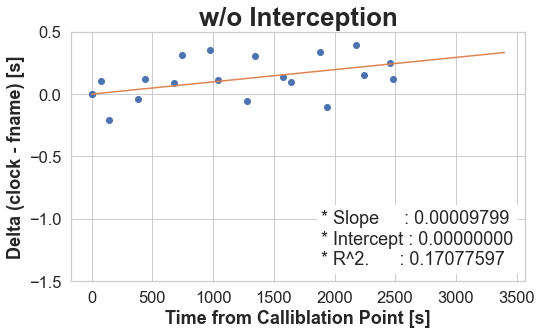

In [11]:
# == Plot ==
fig, ax0 = plt.subplots(1, 1, figsize=(8, 5))

# Raw data
ax0.scatter(x, y, color="C0")

# Trend Line
xloc = np.arange(0, 3500, 100)
y_pred = model.predict(xloc.reshape(-1, 1))
ax0.plot(xloc, y_pred, color="C1")

# Memo
ax0.text(
    0.550, 0.05,
    (
        f"* Slope     : {model.coef_[0]:.8f}\n"
        f"* Intercept : {model.intercept_:.8f}\n"
        f"* R^2.      : {model.score(x, y):.8f}"        
    ),
    backgroundcolor="white",
    ha="left", va="bottom",
    transform=ax0.transAxes,
)

ax0.set_xlabel("Time from Calliblation Point [s]", fontweight="bold")
ax0.set_ylabel("Delta (clock - fname) [s]", fontweight="bold")
ax0.set_ylim([-1.5, 0.5])
ax0.set_title("w/o Interception", fontsize="x-large", fontweight="bold")

fig.tight_layout()
fig.show()